## Definindo a pasta de partida dos comandos

Case de estudo com agradecimentos ao dataset 3w: https://github.com/ricardovvargas/3w_dataset

A partir do arquivo pickle resultante do tratamento dos dados vamos aplicar os modelos!

## Carregando as bases:

Carregando dados

In [ ]:
import pickle

In [ ]:
filename = 'anomaly_ts_data.pickle'
with open(filename, 'rb') as picklefile:
  all_data = pickle.load(picklefile)

In [ ]:
X_train = all_data['X_train'].reset_index(drop=True)
y_train = all_data['y_train']
X_test = all_data['X_test'].reset_index(drop=True)
y_test = all_data['y_test']
X_val = all_data['X_val'].reset_index(drop=True)
y_val = all_data['y_val']

Checar brevemente se está tudo ok

In [ ]:
X_train.head()

,P-PDG__median,P-PDG__mean,P-PDG__standard_deviation,P-PDG__variance,P-PDG__root_mean_square,P-PDG__maximum,P-PDG__absolute_maximum,P-PDG__minimum,P-TPT__median,P-TPT__mean,...,P-MON-CKP__absolute_maximum,P-MON-CKP__minimum,T-JUS-CKP__median,T-JUS-CKP__mean,T-JUS-CKP__standard_deviation,T-JUS-CKP__variance,T-JUS-CKP__root_mean_square,T-JUS-CKP__maximum,T-JUS-CKP__absolute_maximum,T-JUS-CKP__minimum
0,420.26990,420.269900,1.705303e-13,2.908057e-26,420.269900,420.2699,420.2699,420.2699,174.6979,174.6979,...,96.18252,96.18252,66.86504,66.86504,1.421085e-14,2.019484e-28,66.86504,66.86504,66.86504,66.86504
1,420.24420,420.244200,5.684342e-14,3.231174e-27,420.244200,420.2442,420.2442,420.2442,175.3406,175.3406,...,96.64524,96.64524,66.86504,66.86504,1.421085e-14,2.019484e-28,66.86504,66.86504,66.86504,66.86504
2,420.24420,420.244200,5.684342e-14,3.231174e-27,420.244200,420.2442,420.2442,420.2442,175.3406,175.3406,...,96.64524,96.64524,66.86504,66.86504,1.421085e-14,2.019484e-28,66.86504,66.86504,66.86504,66.86504
3,420.24745,420.247661,2.856784e-03,8.161216e-06,420.247661,420.2529,420.2529,420.2442,175.3406,175.3406,...,96.64524,96.64524,66.86504,66.86504,1.421085e-14,2.019484e-28,66.86504,66.86504,66.86504,66.86504
4,420.23140,420.230848,9.928043e-04,9.856604e-07,420.230848,420.2314,420.2314,420.2280,175.5013,175.5013,...,96.64524,96.64524,66.75450,66.75450,0.000000e+00,0.000000e+00,66.75450,66.75450,66.75450,66.75450


In [ ]:
X_train.shape, X_test.shape, X_val.shape

((90, 40), (215, 40), (192, 40))

## Aplicar aos modelos

### Autoencoder

####  Treino

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import logging


# set random seed for reproducibility
tensorflow.random.set_seed(2022)
np.random.seed(2022)
np.random.RandomState(2022)
random.seed(2022)

In [ ]:
X_train.shape[1]

40

In [ ]:
# definição do modelo

input_feats = X_train.shape[1]
hidden_neurons = [64, 16]
latent_dim = 8

# Encoder
inputs = Input(shape=(input_feats,), name='encoder_input')
enc_hidden = Dense(hidden_neurons[0], activation='linear', name='encoder_hidden_0')(inputs)
enc_hidden = Dropout(0.15)(enc_hidden)
enc_hidden = Dense(hidden_neurons[1], activation='linear', name='encoder_hidden_1')(enc_hidden)
enc_hidden = Dropout(0.25)(enc_hidden)

# Camada Latente
z_ = Dense(latent_dim, name='z_')(enc_hidden)

encoder = Model(inputs, z_, name='encoder')
logging.info(encoder.summary())

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_')
dec_hidden = Dense(hidden_neurons[1], activation='linear', name='decoder_hidden_0')(latent_inputs)
dec_hidden = Dropout(0.15)(dec_hidden)
dec_hidden = Dense(hidden_neurons[0], activation='linear', name='decoder_hidden_1')(dec_hidden)
dec_hidden = Dropout(0.25)(dec_hidden)


outputs = Dense(input_feats, activation='linear',
                name='decoder_output')(dec_hidden)

decoder = Model(latent_inputs, outputs, name='decoder')
logging.info(decoder.summary())


outputs = decoder(encoder(inputs))

model = Model(inputs, outputs, name='ae')

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics='mse');

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 40)]              0         
                                                                 
 encoder_hidden_0 (Dense)    (None, 64)                2624      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 encoder_hidden_1 (Dense)    (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 z_ (Dense)                  (None, 8)                 136       
                                                                 
Total params: 3,800
Trainable params: 3,800
Non-trainable p

In [ ]:
monitor = 'val_mse'
lr_reduce = ReduceLROnPlateau(monitor=monitor, factor=0.6, min_delta=0.0001, patience=8, verbose=1)
early = EarlyStopping(monitor=monitor, mode="min", patience=25)
kwargs = {}
kwargs['epochs'] = 250
kwargs['batch_size'] = 32
kwargs['shuffle'] = True
kwargs['validation_data'] = (X_test, X_test)
kwargs['verbose'] = 1
kwargs['callbacks'] = [early, lr_reduce]

history = model.fit(X_train, X_train, **kwargs)

Epoch 1/250
3/3 [==============================] - 1s 139ms/step - loss: 123938.0703 - mse: 123938.0703 - val_loss: 54104.7734 - val_mse: 54104.7734 - lr: 0.0010
Epoch 2/250
3/3 [==============================] - 0s 26ms/step - loss: 69190.4766 - mse: 69190.4766 - val_loss: 38350.9961 - val_mse: 38350.9961 - lr: 0.0010
Epoch 3/250
3/3 [==============================] - 0s 28ms/step - loss: 54469.7891 - mse: 54469.7891 - val_loss: 33892.7031 - val_mse: 33892.7031 - lr: 0.0010
Epoch 4/250
3/3 [==============================] - 0s 28ms/step - loss: 47197.9492 - mse: 47197.9492 - val_loss: 32680.7168 - val_mse: 32680.7168 - lr: 0.0010
Epoch 5/250
3/3 [==============================] - 0s 23ms/step - loss: 46976.1836 - mse: 46976.1836 - val_loss: 32217.9141 - val_mse: 32217.9141 - lr: 0.0010
Epoch 6/250
3/3 [==============================] - 0s 26ms/step - loss: 41504.9883 - mse: 41504.9883 - val_loss: 31401.6309 - val_mse: 31401.6309 - lr: 0.0010
Epoch 7/250
3/3 [==========================

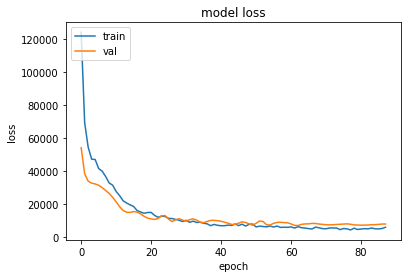

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

(array([71., 13.,  7.,  6.,  5.,  5.,  2.,  3.,  1.,  5.,  3., 10.,  5.,
         4.,  6.,  9.,  8.,  9.,  7., 36.]),
 array([  721.67386609,  1572.71399724,  2423.75412839,  3274.79425953,
         4125.83439068,  4976.87452183,  5827.91465297,  6678.95478412,
         7529.99491526,  8381.03504641,  9232.07517756, 10083.1153087 ,
        10934.15543985, 11785.195571  , 12636.23570214, 13487.27583329,
        14338.31596444, 15189.35609558, 16040.39622673, 16891.43635787,
        17742.47648902]),
 <a list of 20 Patch objects>)

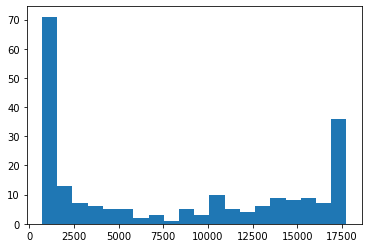

In [ ]:
preds = model.predict(X_test)
scores = np.mean(np.power(X_test - preds, 2), axis=1)
scores_to_define_threshold = np.mean(np.power(X_test - preds, 2), axis=1)
plt.hist(scores, bins=20)

In [ ]:
threshold = 6000
scores[scores < threshold] = -999
scores[scores >= threshold] = int(-1)
scores[scores == -999] = int(1)
# scores[scores.isna()] = int(1)
y_pred = np.array(scores)

In [ ]:
def get_confusion_matrix(y_real, y_pred, model_name=None):
    y_real_list = list(y_real)
    y_pred_list = list(y_pred)
    cm = confusion_matrix(y_true=y_real_list, y_pred=y_pred_list)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')

    ax.set_title(model_name + ' Confusion Matrix with labels')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')

    # Ticket labels - As listas devem estar em ordem alfabetica
    ax.xaxis.set_ticklabels(['-1', '1'])
    ax.yaxis.set_ticklabels(['-1', '1'])
    plt.show()
    return cm

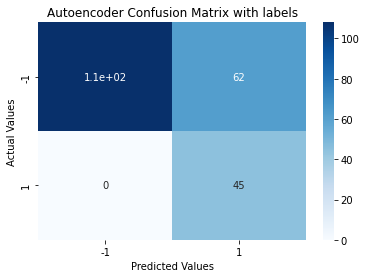

(0.7116279069767442, 0.7116279069767442, 0.7116279069767442, None)


In [ ]:
# Calcula todas as métricas e exibe a matriz de confusão
cm = get_confusion_matrix(y_real=y_test, y_pred=y_pred, model_name="Autoencoder")

ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(ret)
# p, r, f1, _ = ret

Vamos encontrar o melhor valor de threshold

In [ ]:
erros = [(i, val_y_test, val_y_pred, scores_to_define_threshold[i]) for i, (val_y_test, val_y_pred) in enumerate(zip(y_test, y_pred)) if val_y_test != val_y_pred]
print(min([cada_erro[3] for cada_erro in erros]))
erros

772.6523018475909


[(70, -1.0, 1.0, 5372.263823268318),
 (73, -1.0, 1.0, 1234.5902481453902),
 (75, -1.0, 1.0, 898.7484402324346),
 (76, -1.0, 1.0, 4549.816291197612),
 (78, -1.0, 1.0, 4141.310896597884),
 (79, -1.0, 1.0, 1043.9142125501712),
 (80, -1.0, 1.0, 1178.9926242034053),
 (81, -1.0, 1.0, 3664.109369109751),
 (83, -1.0, 1.0, 1685.457117723702),
 (85, -1.0, 1.0, 1880.8933192656036),
 (86, -1.0, 1.0, 2748.1334881988664),
 (88, -1.0, 1.0, 3677.6089274087694),
 (89, -1.0, 1.0, 3136.621735519219),
 (91, -1.0, 1.0, 5133.77008344412),
 (93, -1.0, 1.0, 1605.1748220388072),
 (94, -1.0, 1.0, 820.0941467106775),
 (95, -1.0, 1.0, 2990.3711808353573),
 (99, -1.0, 1.0, 772.6523018475909),
 (101, -1.0, 1.0, 4670.717001801752),
 (102, -1.0, 1.0, 1157.7346932436155),
 (103, -1.0, 1.0, 2038.111657980388),
 (104, -1.0, 1.0, 1433.180896567496),
 (105, -1.0, 1.0, 3459.3269062290697),
 (106, -1.0, 1.0, 2276.2039760559355),
 (107, -1.0, 1.0, 856.4917989181611),
 (108, -1.0, 1.0, 1406.5120174093763),
 (114, -1.0, 1.0, 1

In [ ]:
preds = model.predict(X_test)
scores = np.mean(np.power(X_test - preds, 2), axis=1)

threshold = 772
scores[scores < threshold] = -999
scores[scores >= threshold] = int(-1)
scores[scores == -999] = int(1)
# scores[scores.isna()] = int(1)
y_pred = np.array(scores)

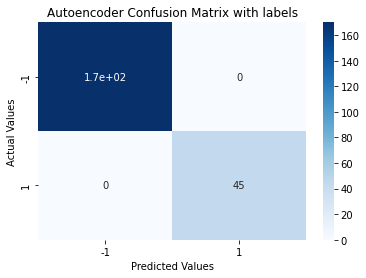

(1.0, 1.0, 1.0, None)


In [ ]:
cm = get_confusion_matrix(y_real=y_test, y_pred=y_pred, model_name="Autoencoder")

ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(ret)

#### Aplicando sobre o dataset de validação

In [ ]:
preds_val = model.predict(X_val)
scores_val = np.mean(np.power(X_val - preds_val, 2), axis=1)

scores_val[scores_val < threshold] = -999
scores_val[scores_val >= threshold] = int(-1)
scores_val[scores_val == -999] = int(1)
# scores_val[scores_val.isna()] = int(1)
y_val_pred = np.array(scores_val)

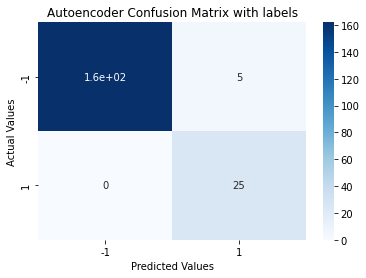

(0.9739583333333334, 0.9739583333333334, 0.9739583333333334, None)


In [ ]:
cm_val = get_confusion_matrix(y_real=y_val, y_pred=y_val_pred, model_name="Autoencoder")

ret_val = precision_recall_fscore_support(y_val, y_val_pred, average='micro')
print(ret_val)

 ### Autoencoder + SVC

#### Treino

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import logging


# set random seed for reproducibility
tensorflow.random.set_seed(2022)
np.random.seed(2022)
np.random.RandomState(2022)
random.seed(2022)

In [ ]:
# definição do modelo

input_feats = X_train.shape[1]
hidden_neurons = [64, 16]
latent_dim = 8

# Encoder
inputs = Input(shape=(input_feats,), name='encoder_input')
enc_hidden = Dense(hidden_neurons[0], activation='linear', name='encoder_hidden_0')(inputs)
enc_hidden = Dropout(0.15)(enc_hidden)
enc_hidden = Dense(hidden_neurons[1], activation='linear', name='encoder_hidden_1')(enc_hidden)
enc_hidden = Dropout(0.25)(enc_hidden)

# Camda Latente
z_ = Dense(latent_dim, name='z_')(enc_hidden)

encoder = Model(inputs, z_, name='encoder')
logging.info(encoder.summary())

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_')
dec_hidden = Dense(hidden_neurons[1], activation='linear', name='decoder_hidden_0')(latent_inputs)
dec_hidden = Dropout(0.15)(dec_hidden)
dec_hidden = Dense(hidden_neurons[0], activation='linear', name='decoder_hidden_1')(dec_hidden)
dec_hidden = Dropout(0.25)(dec_hidden)


outputs = Dense(input_feats, activation='linear',
                name='decoder_output')(dec_hidden)

decoder = Model(latent_inputs, outputs, name='decoder')
logging.info(decoder.summary())


outputs = decoder(encoder(inputs))

model = Model(inputs, outputs, name='ae')

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics='mse');

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 40)]              0         
                                                                 
 encoder_hidden_0 (Dense)    (None, 64)                2624      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 encoder_hidden_1 (Dense)    (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 z_ (Dense)                  (None, 8)                 136       
                                                                 
Total params: 3,800
Trainable params: 3,800
Non-trainable p

In [ ]:
monitor = 'val_mse'
lr_reduce = ReduceLROnPlateau(monitor=monitor, factor=0.6, min_delta=0.0001, patience=8, verbose=1)
early = EarlyStopping(monitor=monitor, mode="min", patience=25)
kwargs = {}
kwargs['epochs'] = 250
kwargs['batch_size'] = 32
kwargs['shuffle'] = True
kwargs['validation_data'] = (X_test, X_test)
kwargs['verbose'] = 1
kwargs['callbacks'] = [early, lr_reduce]

history = model.fit(X_train, X_train, **kwargs)

Epoch 1/250
3/3 [==============================] - 1s 104ms/step - loss: 123938.0703 - mse: 123938.0703 - val_loss: 54104.7734 - val_mse: 54104.7734 - lr: 0.0010
Epoch 2/250
3/3 [==============================] - 0s 21ms/step - loss: 69190.4766 - mse: 69190.4766 - val_loss: 38350.9961 - val_mse: 38350.9961 - lr: 0.0010
Epoch 3/250
3/3 [==============================] - 0s 20ms/step - loss: 54469.7891 - mse: 54469.7891 - val_loss: 33892.7031 - val_mse: 33892.7031 - lr: 0.0010
Epoch 4/250
3/3 [==============================] - 0s 18ms/step - loss: 47197.9492 - mse: 47197.9492 - val_loss: 32680.7168 - val_mse: 32680.7168 - lr: 0.0010
Epoch 5/250
3/3 [==============================] - 0s 25ms/step - loss: 46976.1836 - mse: 46976.1836 - val_loss: 32217.9141 - val_mse: 32217.9141 - lr: 0.0010
Epoch 6/250
3/3 [==============================] - 0s 19ms/step - loss: 41504.9883 - mse: 41504.9883 - val_loss: 31401.6309 - val_mse: 31401.6309 - lr: 0.0010
Epoch 7/250
3/3 [==========================

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [ ]:
preds = model.predict(X_train)
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.001)  # IsolationForest(contamination=0.01)
svm.fit(preds)

OneClassSVM(gamma='auto', nu=0.001)

In [ ]:
y_pred = svm.predict(preds)

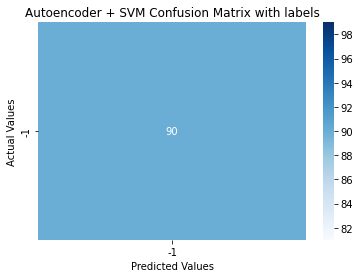

(1.0, 1.0, 1.0, None)


In [ ]:
# Calcula todas as métricas e exibe a matriz de confusão
cm = get_confusion_matrix(y_real=y_train, y_pred=y_pred, model_name="Autoencoder + SVM")

ret = precision_recall_fscore_support(y_train, y_pred, average='micro')
print(ret)
# p, r, f1, _ = ret

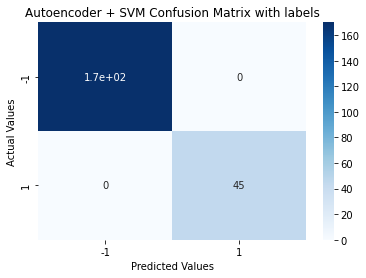

(1.0, 1.0, 1.0, None)


In [ ]:
preds = model.predict(X_test)
y_pred = svm.predict(preds)

# Calcula todas as métricas e exibe a matriz de confusão
cm = get_confusion_matrix(y_real=y_test, y_pred=y_pred, model_name="Autoencoder + SVM")

ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(ret)
# p, r, f1, _ = ret

#### Aplicando sobre o dataset de validação

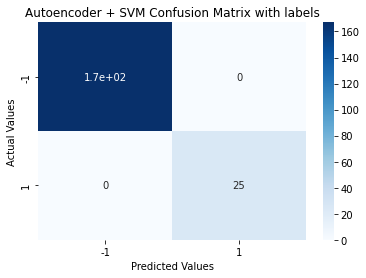

(1.0, 1.0, 1.0, None)


In [ ]:
preds = model.predict(X_val)
y_val_pred = svm.predict(preds)

# Calcula todas as métricas e exibe a matriz de confusão
cm = get_confusion_matrix(y_real=y_val, y_pred=y_val_pred, model_name="Autoencoder + SVM")

ret = precision_recall_fscore_support(y_val, y_val_pred, average='micro')
print(ret)
# p, r, f1, _ = ret

### Variational Autoencoder

#### Treino

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [ ]:
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import logging



# set random seed for reproducibility
tf.random.set_seed(2022)
np.random.seed(2022)
np.random.RandomState(2022)
random.seed(2022)

In [ ]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# definição do modelo

input_feats = X_train_norm.shape[1]
hidden_neurons = [128, 32]
latent_dim = 8

# Encoder
inputs = Input(shape=(input_feats,), name='encoder_input')
enc_hidden = Dense(hidden_neurons[0], activation='linear', name='encoder_hidden_0')(inputs)
enc_hidden = Dropout(0.15)(enc_hidden)
enc_hidden = Dense(hidden_neurons[1], activation='linear', name='encoder_hidden_1')(enc_hidden)
enc_hidden = Dropout(0.25)(enc_hidden)

# Camada Latente
z_mean = Dense(latent_dim, name='z_mean')(enc_hidden)
z_log_var = Dense(latent_dim, name='z_log_var')(enc_hidden)
z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# logging.info(encoder.summary())


# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
dec_hidden = Dense(hidden_neurons[1], activation='linear', name='decoder_hidden_0')(latent_inputs)
dec_hidden = Dropout(0.25)(dec_hidden)
dec_hidden = Dense(hidden_neurons[0], activation='linear', name='decoder_hidden_1')(dec_hidden)
dec_hidden = Dropout(0.15)(dec_hidden)
outputs = Dense(input_feats, activation='linear',
                name='decoder_output')(dec_hidden)

decoder = Model(latent_inputs, outputs, name='decoder')
# logging.info(decoder.summary())

# Definindo o modelo VAE
outputs = decoder(encoder(inputs)[2])
model = Model(inputs, outputs, name='vae')
logging.info(model.summary())

# Adicionando métrica para reconstrução do VAE
reconstruction_loss = keras.losses.mse(inputs, outputs)
reconstruction_loss *= input_feats
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
model.add_loss(vae_loss)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer);

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 40)]              0         
                                                                 
 encoder (Functional)        [(None, 8),               9904      
                              (None, 8),                         
                              (None, 8)]                         
                                                                 
 decoder (Functional)        (None, 40)                9672      
                                                                 
Total params: 19,576
Trainable params: 19,576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
monitor = 'loss'
lr_reduce = ReduceLROnPlateau(monitor=monitor, factor=0.6, min_delta=0.0001, patience=8, verbose=1)
early = EarlyStopping(monitor=monitor, mode="min", patience=25)
kwargs = {}
kwargs['epochs'] = 250
kwargs['batch_size'] = 64
kwargs['shuffle'] = True
kwargs['validation_data'] = (X_test_norm, X_test_norm)
kwargs['verbose'] = 1
kwargs['callbacks'] = [early, lr_reduce]

history = model.fit(X_train_norm, X_train_norm, **kwargs)

Epoch 1/250
2/2 [==============================] - 1s 229ms/step - loss: 80.4951 - val_loss: nan - lr: 0.0010
Epoch 2/250
2/2 [==============================] - 0s 37ms/step - loss: 46.0295 - val_loss: nan - lr: 0.0010
Epoch 3/250
2/2 [==============================] - 0s 62ms/step - loss: 38.0550 - val_loss: nan - lr: 0.0010
Epoch 4/250
2/2 [==============================] - 0s 37ms/step - loss: 31.8496 - val_loss: nan - lr: 0.0010
Epoch 5/250
2/2 [==============================] - 0s 33ms/step - loss: 30.1235 - val_loss: nan - lr: 0.0010
Epoch 6/250
2/2 [==============================] - 0s 56ms/step - loss: 27.3982 - val_loss: nan - lr: 0.0010
Epoch 7/250
2/2 [==============================] - 0s 48ms/step - loss: 26.7239 - val_loss: nan - lr: 0.0010
Epoch 8/250
2/2 [==============================] - 0s 37ms/step - loss: 22.5514 - val_loss: nan - lr: 0.0010
Epoch 9/250
2/2 [==============================] - 0s 53ms/step - loss: 21.1701 - val_loss: nan - lr: 0.0010
Epoch 10/250
2/2 [

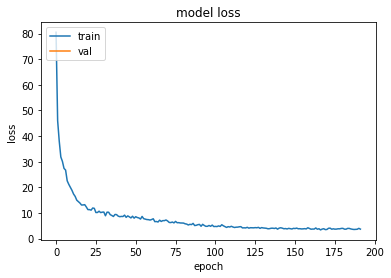

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

(array([214.,   0.,   0.,   0.,   1.]),
 array([7.73059982e-03, 5.15870970e+68, 1.03174194e+69, 1.54761291e+69,
        2.06348388e+69, 2.57935485e+69]),
 <a list of 5 Patch objects>)

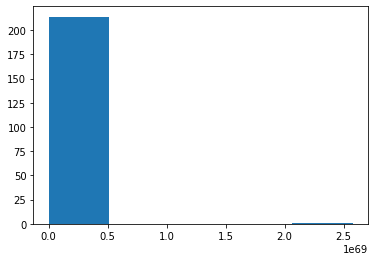

In [ ]:
preds = model.predict(X_test_norm)
scores = np.mean(np.power(X_test_norm - preds, 2), axis=1)
scores_to_define_threshold = np.mean(np.power(X_test_norm - preds, 2), axis=1)
plt.hist(scores, bins=5)

In [ ]:
threshold = 6000
scores[scores < threshold] = -999
scores[scores >= threshold] = int(-1)
scores[scores == -999] = int(1)
# scores[scores.isna()] = int(1)
y_pred = np.array(scores)

In [ ]:
def get_confusion_matrix(y_real, y_pred, model_name=None):
    y_real_list = list(y_real)
    y_pred_list = list(y_pred)
    cm = confusion_matrix(y_true=y_real_list, y_pred=y_pred_list)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')

    ax.set_title(model_name + ' Confusion Matrix with labels')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')

    # Ticket labels - As listas devem estar em ordem alfabetica
    ax.xaxis.set_ticklabels(['-1', '1'])
    ax.yaxis.set_ticklabels(['-1', '1'])
    plt.show()
    return cm

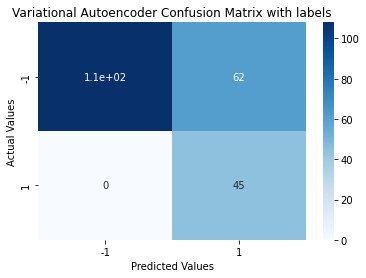

(0.7116279069767442, 0.7116279069767442, 0.7116279069767442, None)


In [ ]:
# Calcula todas as métricas e exibe a matriz de confusão
cm = get_confusion_matrix(y_real=y_test, y_pred=y_pred, model_name="Variational Autoencoder")

ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(ret)
# p, r, f1, _ = ret

In [ ]:
erros = [(i, val_y_test, val_y_pred, scores_to_define_threshold[i]) for i, (val_y_test, val_y_pred) in enumerate(zip(y_test, y_pred)) if val_y_test != val_y_pred]
print(min([cada_erro[3] for cada_erro in erros]))
erros

0.18104247677377697


[(70, -1.0, 1.0, 2203.6376537932238),
 (73, -1.0, 1.0, 48.67027293358895),
 (75, -1.0, 1.0, 4.976513783983612),
 (76, -1.0, 1.0, 472.84980131819765),
 (78, -1.0, 1.0, 390.2124566106853),
 (79, -1.0, 1.0, 18.589331077123155),
 (80, -1.0, 1.0, 38.627042073833785),
 (81, -1.0, 1.0, 702.8674654665093),
 (83, -1.0, 1.0, 128.89758043551777),
 (85, -1.0, 1.0, 163.13396966892054),
 (86, -1.0, 1.0, 392.77635486928364),
 (88, -1.0, 1.0, 413.8144672318711),
 (89, -1.0, 1.0, 336.23607954314286),
 (91, -1.0, 1.0, 1905.422555876261),
 (93, -1.0, 1.0, 106.43595507322046),
 (94, -1.0, 1.0, 1.5065718930316836),
 (95, -1.0, 1.0, 382.87698420822096),
 (99, -1.0, 1.0, 0.18104247677377697),
 (101, -1.0, 1.0, 767.9051586572959),
 (102, -1.0, 1.0, 35.82874254358704),
 (103, -1.0, 1.0, 196.8041351638577),
 (104, -1.0, 1.0, 81.37465780673244),
 (105, -1.0, 1.0, 392.7412886127912),
 (106, -1.0, 1.0, 227.5100363801076),
 (107, -1.0, 1.0, 2.2351612482078513),
 (108, -1.0, 1.0, 77.31306070876724),
 (114, -1.0, 1.0

In [ ]:
preds = model.predict(X_test_norm)
scores = np.mean(np.power(X_test_norm - preds, 2), axis=1)

threshold = 0.181
scores[scores < threshold] = -999
scores[scores >= threshold] = int(-1)
scores[scores == -999] = int(1)
# scores[scores.isna()] = int(1)
y_pred = np.array(scores)

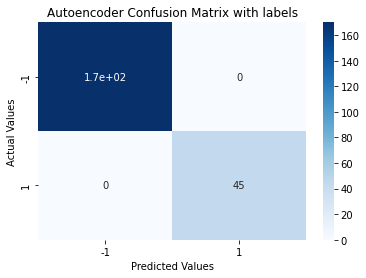

(1.0, 1.0, 1.0, None)


In [ ]:
cm = get_confusion_matrix(y_real=y_test, y_pred=y_pred, model_name="Autoencoder")

ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(ret)

#### Aplicando sobre o dataset de validação

In [ ]:
X_val_norm = scaler.transform(X_val)
preds_val = model.predict(X_val_norm)
scores_val = np.mean(np.power(X_val_norm - preds_val, 2), axis=1)

scores_val[scores_val < threshold] = -999
scores_val[scores_val >= threshold] = int(-1)
scores_val[scores_val == -999] = int(1)
# scores_val[scores_val.isna()] = int(1)
y_val_pred = np.array(scores_val)

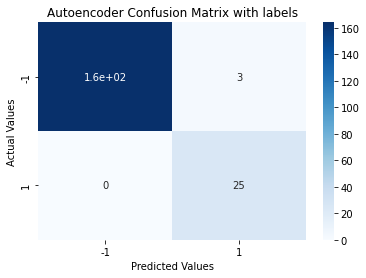

(0.984375, 0.984375, 0.984375, None)


In [ ]:
cm_val = get_confusion_matrix(y_real=y_val, y_pred=y_val_pred, model_name="Autoencoder")

ret_val = precision_recall_fscore_support(y_val, y_val_pred, average='micro')
print(ret_val)